# PQMF filter design example

This notebook is for checking the filter response of PQMF.

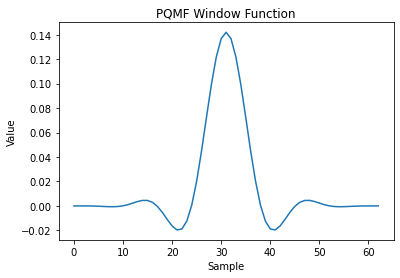

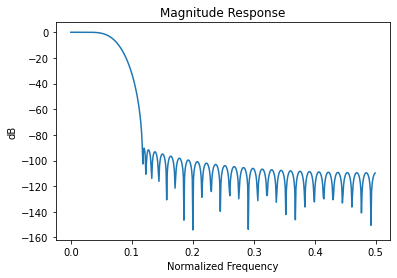

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)
%matplotlib inline

from scipy.signal import freqz
from parallel_wavegan.layers import design_prototype_filter

# check prototype filter
h = design_prototype_filter()

plt.plot(h)
plt.title('PQMF Window Function')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

f, H = freqz(h)
plt.plot(f / (2 * np.pi), 20*np.log10(np.abs(H)))
plt.title('Magnitude Response')
plt.xlabel('Normalized Frequency')
plt.ylabel('dB')
plt.show()

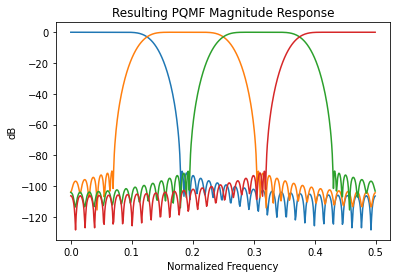

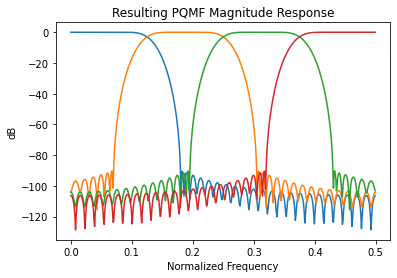

In [2]:
# check PQMF filter
from parallel_wavegan.layers import PQMF
num_subbands = 4
pqmf = PQMF(num_subbands)

analysis_filter = pqmf.analysis_filter[:, 0]
synthesis_filter = pqmf.synthesis_filter[0]
for h in analysis_filter:
    f, H = freqz(h)
    plt.plot(f / (2 * np.pi), 20 * np.log10(np.abs(H)))
    plt.title('Resulting PQMF Magnitude Response')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('dB')
plt.show()
for h in synthesis_filter:
    f, H = freqz(h)
    plt.plot(f / (2 * np.pi), 20 * np.log10(np.abs(H)))
    plt.title('Resulting PQMF Magnitude Response')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('dB')
plt.show()

loss with optimized cutoff ratio = 0.00111516


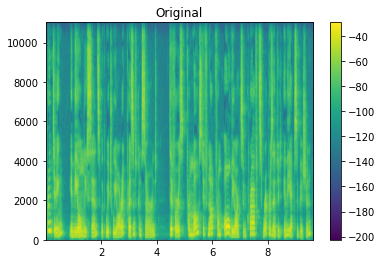

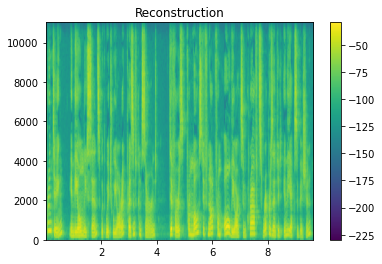

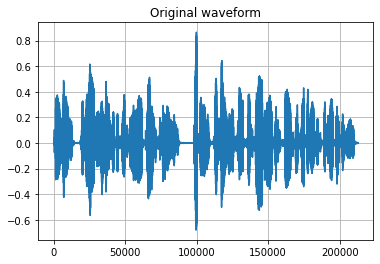

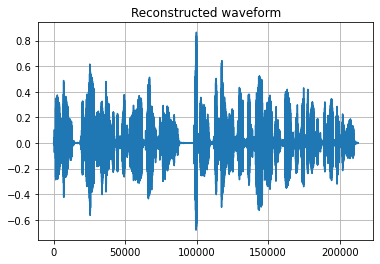

In [3]:
# check reconstruction
import soundfile as sf
import torch
pqmf = PQMF(num_subbands)
wavpath = "../egs/ljspeech/voc1/downloads/LJSpeech-1.1/wavs/LJ001-0001.wav"
x, fs = sf.read(wavpath)
x = torch.from_numpy(x).view(1, 1, -1).float()
y = pqmf.analysis(x)
x_hat = pqmf.synthesis(y)
loss = torch.nn.functional.mse_loss(
    x[..., :x_hat.shape[-1]],
    x_hat[..., :x_hat.shape[-1]],
    reduction="sum"
)
print(f"loss with optimized cutoff ratio = {loss.item():.08f}")

from IPython.display import Audio, display
plt.specgram(x[0, 0].numpy(), Fs=fs)
plt.colorbar()
plt.title("Original")
plt.show()
display(Audio(x[0, 0].numpy(), rate=fs))

plt.specgram(x_hat[0, 0].numpy(), Fs=fs)
plt.colorbar()
plt.title("Reconstruction")
plt.show()
display(Audio(x_hat[0, 0].numpy(), rate=fs))

plt.plot(x[0, 0].numpy())
plt.title("Original waveform")
plt.grid()
plt.show()
display(Audio(x[0, 0].numpy(), rate=fs))

plt.plot(x_hat[0, 0].numpy())
plt.title("Reconstructed waveform")
plt.grid()
plt.show()
display(Audio(x_hat[0, 0].numpy(), rate=fs))

## Optimize filter parameter

This is the procedure to optimize filter parameter by [@tosaka-m](https://github.com/tosaka-m).  
See discussion in https://github.com/kan-bayashi/ParallelWaveGAN/issues/195.

In [4]:
def _objective(cutoff_ratio):
    h_proto = design_prototype_filter(num_taps, cutoff_ratio, beta)
    conv_h_proto = np.convolve(h_proto, h_proto[::-1], mode='full')
    length_conv_h = conv_h_proto.shape[0]
    half_length = length_conv_h // 2

    check_steps = np.arange((half_length) // (2 * num_subbands)) * 2 * num_subbands
    _phi_new = conv_h_proto[half_length:][check_steps]
    phi_new = np.abs(_phi_new[1:]).max()
    # Since phi_new is not convex, This value should also be considered. 
    diff_zero_coef = np.abs(_phi_new[0] - 1 / (2 * num_subbands))
    
    return phi_new + diff_zero_coef

import scipy.optimize as optimize

num_subbands = 8
num_taps = 62
beta = 9.0

ret = optimize.minimize(_objective, np.array([0.01]), 
                        bounds=optimize.Bounds(0.01, 0.99))
opt_cutoff_ratio = ret.x[0]
print(f"optimized cutoff ratio = {opt_cutoff_ratio:.08f}")

optimized cutoff ratio = 0.07949452


loss with optimized cutoff ratio = 0.03786433


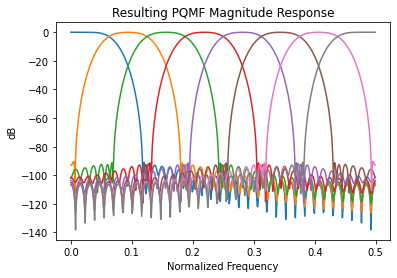

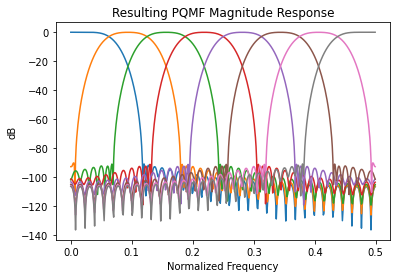

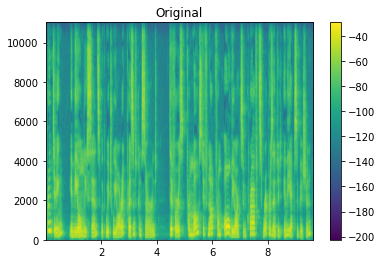

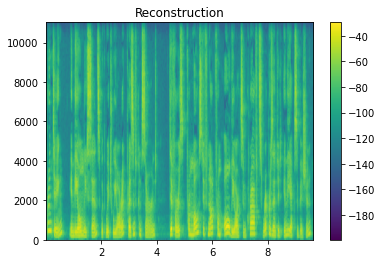

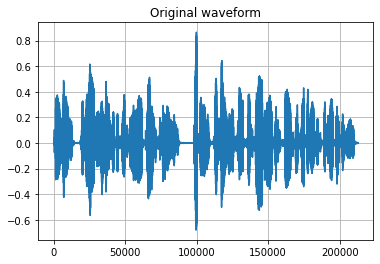

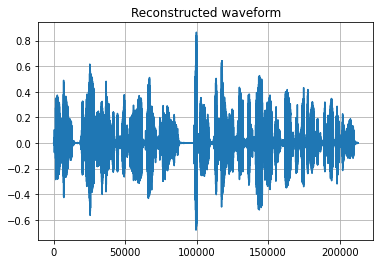

In [5]:
wavpath = "../egs/ljspeech/voc1/downloads/LJSpeech-1.1/wavs/LJ001-0001.wav"
x, fs = sf.read(wavpath)
x = torch.from_numpy(x).view(1, 1, -1).float()
pqmf = PQMF(num_subbands, cutoff_ratio=opt_cutoff_ratio)
y = pqmf.analysis(x)
x_hat = pqmf.synthesis(y)
loss = torch.nn.functional.mse_loss(
    x[..., :x_hat.shape[-1]],
    x_hat[..., :x_hat.shape[-1]],
    reduction="sum"
)
print(f"loss with optimized cutoff ratio = {loss.item():.08f}")

analysis_filter = pqmf.analysis_filter[:, 0]
synthesis_filter = pqmf.synthesis_filter[0]
for h in analysis_filter:
    f, H = freqz(h)
    plt.plot(f / (2 * np.pi), 20*np.log10(np.abs(H)))
    plt.title('Resulting PQMF Magnitude Response')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('dB')
plt.show()
for h in synthesis_filter:
    f, H = freqz(h)
    plt.plot(f / (2 * np.pi), 20*np.log10(np.abs(H)))
    plt.title('Resulting PQMF Magnitude Response')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('dB')
plt.show()

plt.specgram(x[0, 0].numpy(), Fs=fs)
plt.colorbar()
plt.title("Original")
plt.show()
display(Audio(x[0, 0].numpy(), rate=fs))

plt.specgram(x_hat[0, 0].numpy(), Fs=fs)
plt.colorbar()
plt.title("Reconstruction")
plt.show()
display(Audio(x_hat[0, 0].numpy(), rate=fs))

plt.plot(x[0, 0].numpy())
plt.title("Original waveform")
plt.grid()
plt.show()
display(Audio(x[0, 0].numpy(), rate=fs))

plt.plot(x_hat[0, 0].numpy())
plt.title("Reconstructed waveform")
plt.grid()
plt.show()
display(Audio(x_hat[0, 0].numpy(), rate=fs))